# Read in netcdfs, and plot results

## should put stats in another notebook or make it into a function at least

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import seaborn as sns
import scipy.stats # to calculate correlation

In [2]:
# import custom functions
import sys 
# sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook
sys.path.append('/g/data/w48/kb6999/Functions') # use this if the function file is in a different directory to the notebook


import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
import dask.distributed
import tempfile

tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46001 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:34207 Dashboard: http://127.0.0.1:46001/status,Cluster Workers: 2 Cores: 2 Memory: 11.23 GiB


## Open datasets of means and percentiles for plotting

In [4]:
import gzip

In [ ]:
with gzip.open('/home/563/kb6999/cru_ts4.05.1901.2020.pre.dat.nc.gz') as gz:
    crut_ts4 = xr.open_dataset(gz)

In [4]:
# open the observational dataset CRUT. which has rainfall over land
# it has monthly anomalies relative to a 1961-1990 climatology 
cru_ts4 = xr.open_dataset('/home/563/kb6999/cru_ts4.05.1901.2020.pre.dat.nc')
# # rename lat and lon coords and select out time so same as 20CR
# cru_ts4 = cru_ts4.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=slice('1850','2015'))
cru_ts4

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1440)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 1900-01-01
Data variables:
    pre      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.05 Precipitation
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2103051243. Data generated from:pre.2103041709.dtb
    history:      Fri  5 Mar 14:41:58 GMT 2021 : User harry : Program makegri...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [5]:
cru_ts4 = xr.Dataset({'pr': cru_ts4.pre})
cru_ts4

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1440)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 1900-01-01
Data variables:
    pr       (time, lat, lon) float32 ...

In [ ]:
# kernel keeps dying here - seems to be a problem with the cru ts data 

In [ ]:
cru_ts4.pr.mean(dim=['lat','lon'])

In [ ]:
# adjust the hadcrut data to a base climatology of 1850-1880
cru_ts4_anom = func.monthly_anomaly(cru_ts4, '1850-01', '1880-01')

# 20CR data

In [10]:
path = '/g/data/w48/kb6999/Reanalysis/20CR_PRATE_data_for_plots/'

In [11]:
# open lat lon mean of temperature 
llm_Glob = xr.open_dataset(f'{path}llm_pr_Glob.nc')
llm_NH = xr.open_dataset(f'{path}llm_pr_NH.nc')
llm_SH = xr.open_dataset(f'{path}llm_pr_SH.nc')
llm_Aus = xr.open_dataset(f'{path}llm_pr_Aus.nc')
llm_EA = xr.open_dataset(f'{path}llm_pr_EA.nc')

In [12]:
# open multi member mean of temperature
mmm_mon_Glob = xr.open_dataset(f'{path}mmm_mon_pr_Glob.nc')
mmm_mon_NH = xr.open_dataset(f'{path}mmm_mon_pr_NH.nc')
mmm_mon_SH = xr.open_dataset(f'{path}mmm_mon_pr_SH.nc')
mmm_mon_Aus = xr.open_dataset(f'{path}mmm_mon_pr_Aus.nc')
mmm_mon_EA = xr.open_dataset(f'{path}mmm_mon_pr_EA.nc')

In [13]:
# open percentile data for temperature
p10_mon_Glob = xr.open_dataset(f'{path}p10_mon_pr_Glob.nc')
p10_mon_NH = xr.open_dataset(f'{path}p10_mon_pr_NH.nc')
p10_mon_SH = xr.open_dataset(f'{path}p10_mon_pr_SH.nc')
p10_mon_Aus = xr.open_dataset(f'{path}p10_mon_pr_Aus.nc')
p10_mon_EA = xr.open_dataset(f'{path}p10_mon_pr_EA.nc')

In [14]:
# open percentile data for temperature
p90_mon_Glob = xr.open_dataset(f'{path}p90_mon_pr_Glob.nc')
p90_mon_NH = xr.open_dataset(f'{path}p90_mon_pr_NH.nc')
p90_mon_SH = xr.open_dataset(f'{path}p90_mon_pr_SH.nc')
p90_mon_Aus = xr.open_dataset(f'{path}p90_mon_pr_Aus.nc')
p90_mon_EA = xr.open_dataset(f'{path}p90_mon_pr_EA.nc')

### select out Krakatoa years 

In [15]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [16]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [17]:
# Zoom in on Krakatoa time period
K_mmm_Glob = mmm_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH = mmm_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus = mmm_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA = mmm_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob = p10_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH = p10_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus = p10_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA = p10_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob = p90_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH = p90_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus = p90_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA = p90_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

## Figures

In [25]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [18]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

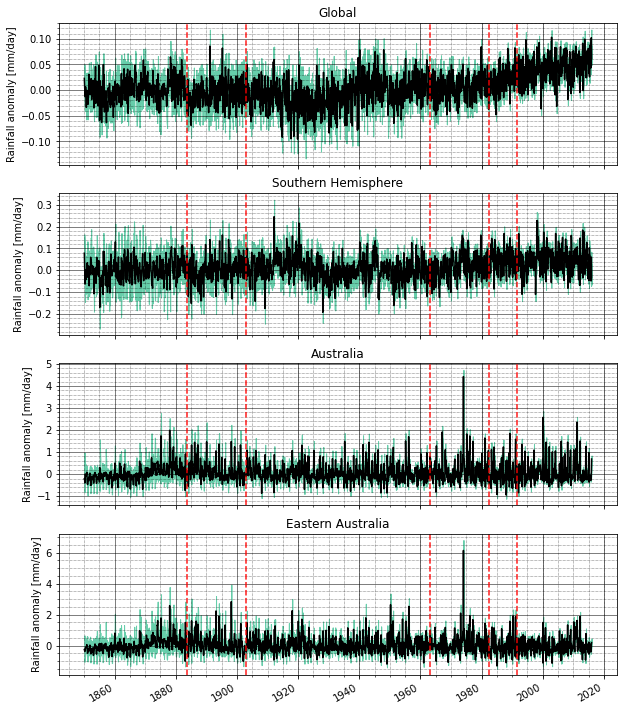

In [19]:
# Monthly rainfall anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob.pr, p10_mon_Glob.pr, p90_mon_Glob.pr, ax = axes[0], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_SH.pr, p10_mon_SH.pr, p90_mon_SH.pr, ax = axes[1], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_Aus.pr, p10_mon_Aus.pr, p90_mon_Aus.pr, ax = axes[2], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_EA.pr, p10_mon_EA.pr, p90_mon_EA.pr, ax = axes[3], color='mediumaquamarine')

axes[0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global') 
axes[1].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia')
axes[3].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_pr_stacked.png', dpi=300, bbox_inches='tight')

In [19]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

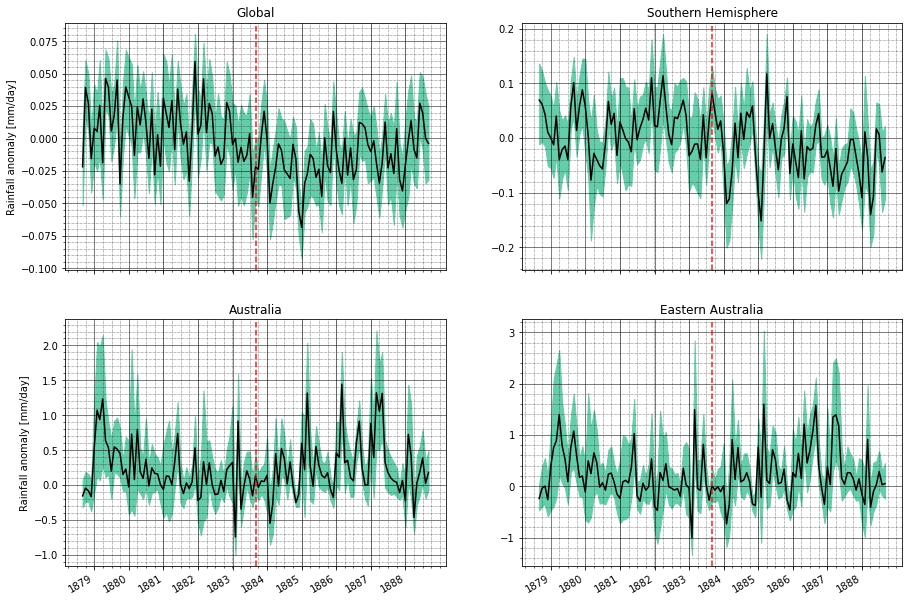

In [23]:
# Monthly rainfall anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob.pr, K_p10_Glob.pr, K_p90_Glob.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_SH.pr, K_p10_SH.pr, K_p90_SH.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus.pr, K_p10_Aus.pr, K_p90_Aus.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_EA.pr, K_p10_EA.pr, K_p90_EA.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr.png', dpi=300, bbox_inches='tight')

## Analysis using Rolling mean 

In [20]:
# calculate rolling means of lat lon data
llm_mon_Glob_roll6 = llm_Glob.rolling(time=6).mean()
llm_mon_NH_roll6 = llm_NH.rolling(time=6).mean()
llm_mon_SH_roll6 = llm_SH.rolling(time=6).mean()
llm_mon_Aus_roll6 = llm_Aus.rolling(time=6).mean()
llm_mon_EA_roll6 = llm_EA.rolling(time=6).mean()

In [21]:
# calculate rolling means
mmm_mon_Glob_roll6 = mmm_mon_Glob.rolling(time=6).mean()
mmm_mon_NH_roll6 = mmm_mon_NH.rolling(time=6).mean()
mmm_mon_SH_roll6 = mmm_mon_SH.rolling(time=6).mean()
mmm_mon_Aus_roll6 = mmm_mon_Aus.rolling(time=6).mean()
mmm_mon_EA_roll6 = mmm_mon_EA.rolling(time=6).mean()

In [22]:
# calculate rolling means
p10_mon_Glob_roll6 = p10_mon_Glob.rolling(time=6).mean()
p10_mon_NH_roll6 = p10_mon_NH.rolling(time=6).mean()
p10_mon_SH_roll6 = p10_mon_SH.rolling(time=6).mean()
p10_mon_Aus_roll6 = p10_mon_Aus.rolling(time=6).mean()
p10_mon_EA_roll6 = p10_mon_EA.rolling(time=6).mean()

In [23]:
# calculate rolling means
p90_mon_Glob_roll6 = p90_mon_Glob.rolling(time=6).mean()
p90_mon_NH_roll6 = p90_mon_NH.rolling(time=6).mean()
p90_mon_SH_roll6 = p90_mon_SH.rolling(time=6).mean()
p90_mon_Aus_roll6 = p90_mon_Aus.rolling(time=6).mean()
p90_mon_EA_roll6 = p90_mon_EA.rolling(time=6).mean()

In [24]:
# 3 month rolling mean and percentiles
mmm_mon_Glob_roll3 = mmm_mon_Glob.rolling(time=3).mean()
mmm_mon_Aus_roll3 = mmm_mon_Aus.rolling(time=3).mean()

p10_mon_Glob_roll3 = p10_mon_Glob.rolling(time=3).mean()
p10_mon_Aus_roll3 = p10_mon_Aus.rolling(time=3).mean()

p90_mon_Glob_roll3 = p90_mon_Glob.rolling(time=3).mean()
p90_mon_Aus_roll3 = p90_mon_Aus.rolling(time=3).mean()

# 12 month rolling mean and percentiles for all 4 regions
mmm_mon_Glob_roll12 = mmm_mon_Glob.rolling(time=12).mean()
mmm_mon_SH_roll12 = mmm_mon_SH.rolling(time=12).mean()
mmm_mon_Aus_roll12 = mmm_mon_Aus.rolling(time=12).mean()
mmm_mon_EA_roll12 = mmm_mon_EA.rolling(time=12).mean()

p10_mon_Glob_roll12 = p10_mon_Glob.rolling(time=12).mean()
p10_mon_SH_roll12 = p10_mon_SH.rolling(time=12).mean()
p10_mon_Aus_roll12 = p10_mon_Aus.rolling(time=12).mean()
p10_mon_EA_roll12 = p10_mon_EA.rolling(time=12).mean()

p90_mon_Glob_roll12 = p90_mon_Glob.rolling(time=12).mean()
p90_mon_SH_roll12 = p90_mon_SH.rolling(time=12).mean()
p90_mon_Aus_roll12 = p90_mon_Aus.rolling(time=12).mean()
p90_mon_EA_roll12 = p90_mon_EA.rolling(time=12).mean()

# 24 month rolling mean and percentiles 
mmm_mon_Glob_roll24 = mmm_mon_Glob.rolling(time=24).mean()
mmm_mon_Aus_roll24 = mmm_mon_Aus.rolling(time=24).mean()

p10_mon_Glob_roll24 = p10_mon_Glob.rolling(time=24).mean()
p10_mon_Aus_roll24 = p10_mon_Aus.rolling(time=24).mean()

p90_mon_Glob_roll24 = p90_mon_Glob.rolling(time=24).mean()
p90_mon_Aus_roll24 = p90_mon_Aus.rolling(time=24).mean()


## Rolling mean

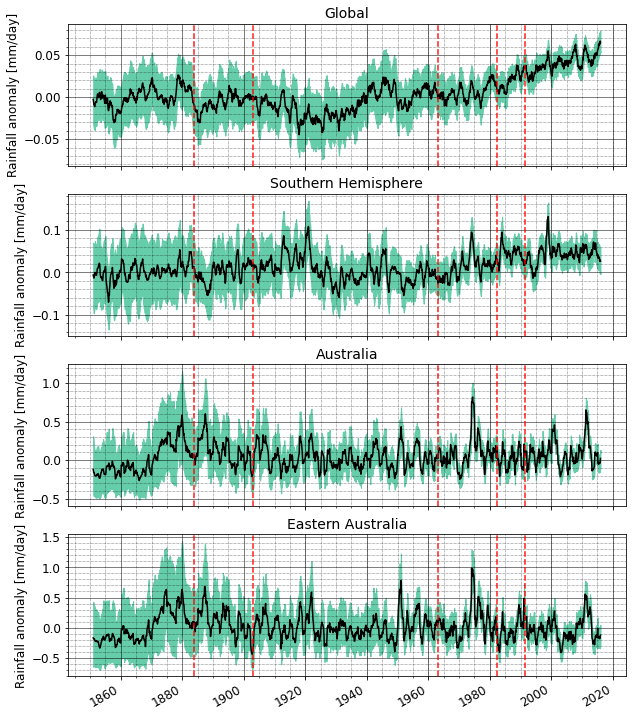

In [26]:
# Monthly rainfall anomalies stacked - rolling mean
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob_roll12.pr, p10_mon_Glob_roll12.pr, p90_mon_Glob_roll12.pr, ax = axes[0], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_SH_roll12.pr, p10_mon_SH_roll12.pr, p90_mon_SH_roll12.pr, ax = axes[1], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_Aus_roll12.pr, p10_mon_Aus_roll12.pr, p90_mon_Aus_roll12.pr, ax = axes[2], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_EA_roll12.pr, p10_mon_EA_roll12.pr, p90_mon_EA_roll12.pr, ax = axes[3], color='mediumaquamarine')

    
axes[0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global') 
axes[1].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia')
axes[3].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_pr_roll12.png', dpi=300, bbox_inches='tight')

In [27]:
# rolling mean version
K_mmm_Glob_roll6 = mmm_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH_roll6 = mmm_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll6 = mmm_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA_roll6 = mmm_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll6 = p10_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH_roll6 = p10_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll6 = p10_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA_roll6 = p10_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll6 = p90_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH_roll6 = p90_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll6 = p90_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA_roll6 = p90_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [28]:
# rolling mean zoomed in for Krakatoa time period
# 3 month rolling mean and precentiles
K_mmm_Glob_roll3 = mmm_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll3 = mmm_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll3 = p10_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll3 = p10_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll3 = p90_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll3 = p90_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

# 12 month rolling mean and precentiles
K_mmm_Glob_roll12 = mmm_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH_roll12 = mmm_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll12 = mmm_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA_roll12 = mmm_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll12 = p10_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH_roll12 = p10_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll12 = p10_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA_roll12 = p10_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll12 = p90_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH_roll12 = p90_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll12 = p90_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA_roll12 = p90_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

# 3 month rolling mean and precentiles
K_mmm_Glob_roll24 = mmm_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll24 = mmm_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll24 = p10_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll24 = p10_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll24 = p90_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll24 = p90_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))


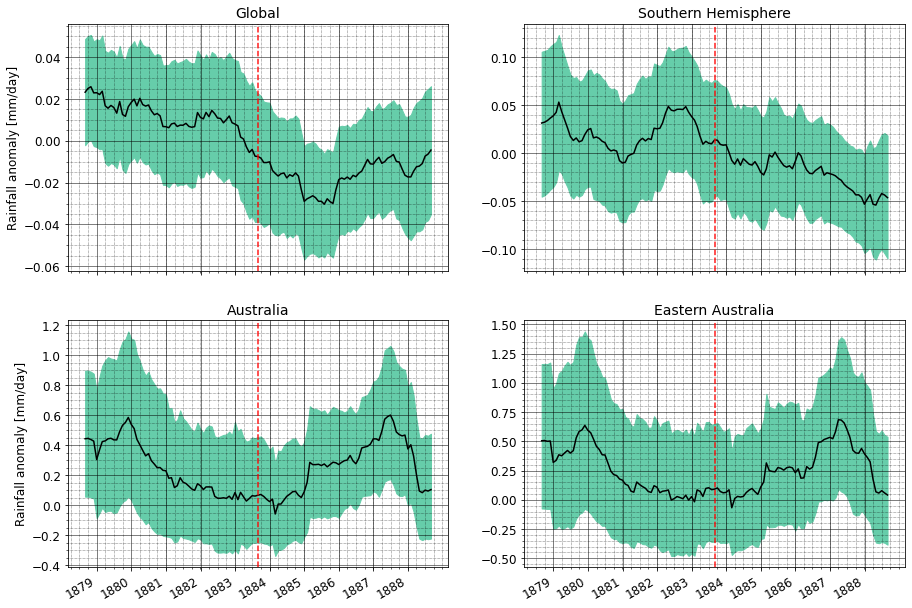

In [29]:
# Monthly rainfall anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob_roll12.pr, K_p10_Glob_roll12.pr, K_p90_Glob_roll12.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_SH_roll12.pr, K_p10_SH_roll12.pr, K_p90_SH_roll12.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll12.pr, K_p10_Aus_roll12.pr, K_p90_Aus_roll12.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_EA_roll12.pr, K_p10_EA_roll12.pr, K_p90_EA_roll12.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr_roll12.png', dpi=300, bbox_inches='tight')

## stats

### ten years around Krakatoa

In [73]:
# calculate the correlation coefficient using different methods for the ten years surrounds the krakatoa eruption 
print(scipy.stats.pearsonr(K_hadcrut5_llm, K_mmm_Glob.pr))#[0]    # Pearson's r

(0.7313668404944029, 1.6413447832258e-21)
SpearmanrResult(correlation=0.693252946755182, pvalue=1.232957959131715e-18)
KendalltauResult(correlation=0.5096418732782368, pvalue=1.1413031832841568e-16)


In [71]:
# calculate correlation using different methods for Australia for the ten years surrounds the krakatoa eruption 
print(scipy.stats.pearsonr(K_hadcrut5_llm_Aus, K_mmm_Aus.pr))#[0]    # Pearson's r

(0.6310991283951795, 8.542760856624406e-15)
SpearmanrResult(correlation=0.6067741498441944, pvalue=1.621003429914607e-13)
KendalltauResult(correlation=0.4352617079889807, pvalue=1.4486341360376614e-12)


In [72]:
# calculate correlation using different methods for Australia for the ten years surrounds the krakatoa eruption 
print(scipy.stats.pearsonr(K_hadcrut5_llm_EA, K_mmm_EA.pr))#[0]    # Pearson's r

(0.5793795367935338, 3.348717364659975e-12)
SpearmanrResult(correlation=0.557559951226121, pvalue=3.0770770561513787e-11)
KendalltauResult(correlation=0.39146005509641874, pvalue=1.9287739474626634e-10)


In [74]:
# calculate the correlation coefficient using different methods for 1870-1900
print(scipy.stats.pearsonr(hadcrut5_llm.sel(time=slice('1870','1900')), mmm_mon_Glob.pr.sel(time=slice('1870','1900'))))#[0]    # Pearson's r

(0.7019206493579492, 1.758877650025233e-56)
SpearmanrResult(correlation=0.6648928767821332, pvalue=8.105401991621983e-49)
KendalltauResult(correlation=0.48300147813233624, pvalue=5.645008292176636e-44)


In [75]:
# calculate the correlation coefficient using different methods for 1970-2000
print(scipy.stats.pearsonr(hadcrut5_llm.sel(time=slice('1970','2000')), mmm_mon_Glob.pr.sel(time=slice('1970','2000'))))#[0]    # Pearson's r

(0.8602087648487855, 2.918998382123444e-110)
SpearmanrResult(correlation=0.841897883690263, pvalue=3.7102737589905693e-101)
KendalltauResult(correlation=0.6490739935657768, pvalue=5.9296378116155e-78)


In [76]:
# calculate the correlation coefficient using different methods for the entire time period
print(scipy.stats.pearsonr(hadcrut5_llm, mmm_mon_Glob.pr))#[0]    # Pearson's r

(0.9250876573289325, 0.0)
SpearmanrResult(correlation=0.8838966858489289, pvalue=0.0)
KendalltauResult(correlation=0.7149038141516343, pvalue=0.0)


Pearson correlation coefficient and p-value for testing non-correlation.

The Pearson correlation coefficient [1] measures the linear relationship between two datasets. The calculation of the p-value relies on the assumption that each dataset is normally distributed. (See Kowalski [3] for a discussion of the effects of non-normality of the input on the distribution of the correlation coefficient.) Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

Calculate Kendall�s tau, a correlation measure for ordinal data.

Kendall�s tau is a measure of the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. This implements two variants of Kendall�s tau: tau-b (the default) and tau-c (also known as Stuart�s tau-c). These differ only in how they are normalized to lie within the range -1 to 1; the hypothesis tests (their p-values) are identical. Kendall�s original tau-a is not implemented separately because both tau-b and tau-c reduce to tau-a in the absence of ties.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

### function below not working, roll should just be a simple 1d array (like mon_array above) but instead it's an xarray

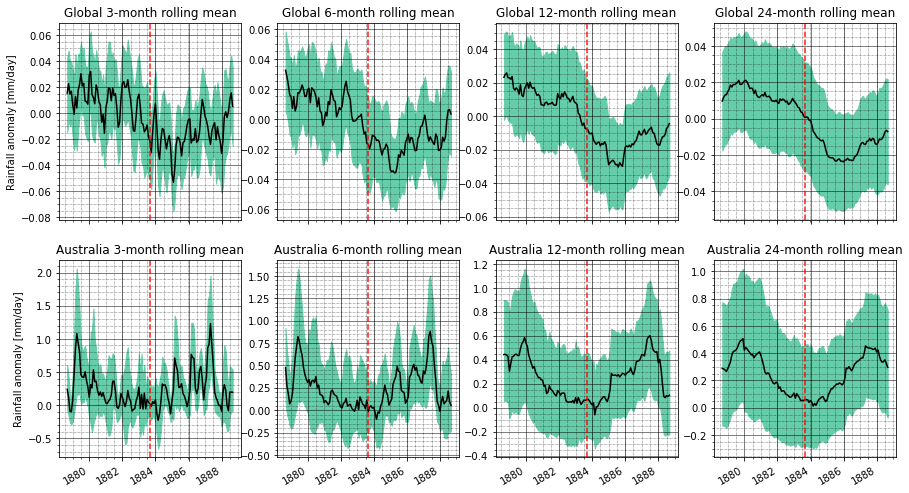

In [34]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(15,8)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob_roll3.pr, K_p10_Glob_roll3.pr, K_p90_Glob_roll3.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Glob_roll6.pr, K_p10_Glob_roll6.pr, K_p90_Glob_roll6.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Glob_roll12.pr, K_p10_Glob_roll12.pr, K_p90_Glob_roll12.pr, ax = axes[0,2], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Glob_roll24.pr, K_p10_Glob_roll24.pr, K_p90_Glob_roll24.pr, ax = axes[0,3], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll3.pr, K_p10_Aus_roll3.pr, K_p90_Aus_roll3.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll6.pr, K_p10_Aus_roll6.pr, K_p90_Aus_roll6.pr, ax = axes[1,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll12.pr, K_p10_Aus_roll12.pr, K_p90_Aus_roll12.pr, ax = axes[1,2], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll24.pr, K_p10_Aus_roll24.pr, K_p90_Aus_roll24.pr, ax = axes[1,3], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global 3-month rolling mean') 
axes[0,1].set(title = 'Global 6-month rolling mean')
axes[0,2].set(title = 'Global 12-month rolling mean')
axes[0,3].set(title = 'Global 24-month rolling mean')
axes[1,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia 3-month rolling mean')
axes[1,1].set(title = 'Australia 6-month rolling mean')
axes[1,2].set(title = 'Australia 12-month rolling mean')
axes[1,3].set(title = 'Australia 24-month rolling mean')



# set the axis ticks to be monthly 
# axes[0,0].set_xticks(years)
# axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr_rolling3-6-12-24.png', dpi=300, bbox_inches='tight')

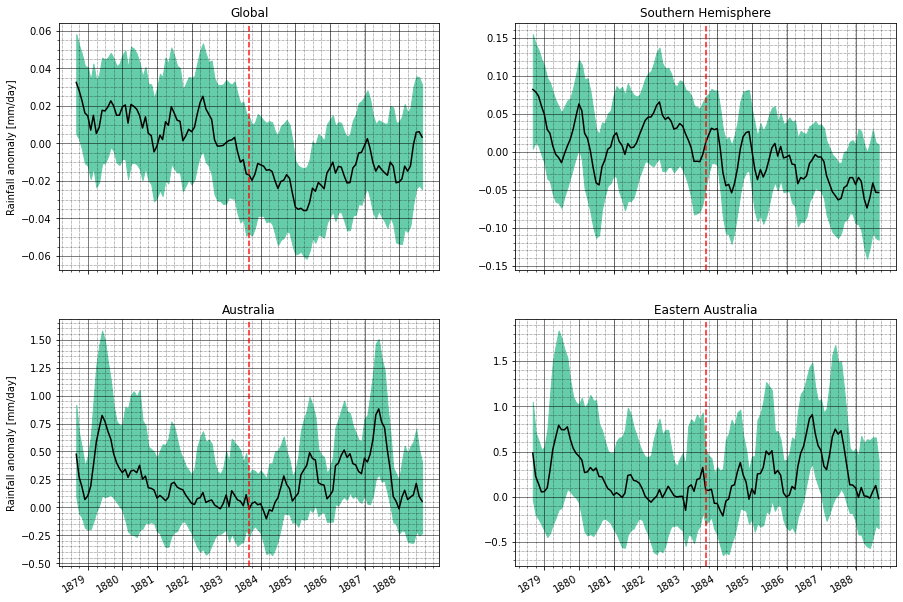

In [38]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob_roll6.pr, K_p10_Glob_roll6.pr, K_p90_Glob_roll6.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_SH_roll6.pr, K_p10_SH_roll6.pr, K_p90_SH_roll6.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll6.pr, K_p10_Aus_roll6.pr, K_p90_Aus_roll6.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_EA_roll6.pr, K_p10_EA_roll6.pr, K_p90_EA_roll6.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr_rolling6.png', dpi=300, bbox_inches='tight')